In [2]:
import regex
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import morfeusz2
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from spacy.tokenizer import Tokenizer
from nlp_common.acts_reader import ActsReader
from collections import Counter
from itertools import chain

### Data preparation

Data used in the exercise comes from two sources: set of polish bills (from previous exercies) and sgjp dictionary. The second one is loaded to elasticsearch in the attached script (main.py).

In [3]:
acts_reader = ActsReader('../ustawy') 
bills = [ text for _, _, text in acts_reader.all_acts()]

### Remove HTML tags

In [4]:
html_regex = regex.compile(r'<\/?[^>]*>', regex.IGNORECASE)
for bill in bills:
    matches = html_regex.findall(bill)
    for match in matches:
        print(match)

< < tajne >


Nothing to clean 🤷

### Tokenize

In [5]:
new_line_re = regex.compile(r'\n+')
bills = [new_line_re.sub(' ', bill) for bill in bills]

In [6]:
nlp = spacy.load("pl_core_news_sm")
prefix_re = regex.compile(r'''^[\[\("'\„]''')
suffix_re = regex.compile(r'''[\]\)"'\:\;\,\.]+$''')
nlp.tokenizer = Tokenizer(nlp.vocab, prefix_search=prefix_re.search, suffix_search=suffix_re.search)

In [7]:
bill_docs = list(nlp.tokenizer.pipe(bills))

### Word counters

In [8]:
ctrs = [ Counter([d.text.lower() for d in doc]) for doc in bill_docs ]

In [9]:
global_counter = Counter()
for ctr in ctrs:
    global_counter += ctr

In [10]:
len(global_counter)

72507

### Rank

In [11]:
# Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).
def reject(word):
    if len(word) < 2 or not regex.match(r'^\p{L}+$', word):
        return True
    return False

word_ctr_pairs = [ (word, global_counter[word]) for word in global_counter ]
word_ctr_pairs_without_rejected = filter(lambda w: not reject(w[0]), word_ctr_pairs)
word_ctr_pairs_sorted = sorted(word_ctr_pairs_without_rejected, key=lambda w: (-w[1], w[0]))
word_ctr_pairs_ranked = map(lambda wi: (wi[1][0], wi[1][1], wi[0]+1), enumerate(word_ctr_pairs_sorted))
df = pd.DataFrame(word_ctr_pairs_ranked, columns=['word', '#occurences', 'rank'])

In [12]:
df

,word,#occurences,rank
0,art,83586,1
1,do,60724,2
2,ust,53367,3
3,na,50639,4
4,się,45864,5
...,...,...,...
54334,żądanego,1,54335
54335,żądaniami,1,54336
54336,żądano,1,54337
54337,żądany,1,54338


### Plot

<AxesSubplot:xlabel='rank', ylabel='#occurences'>

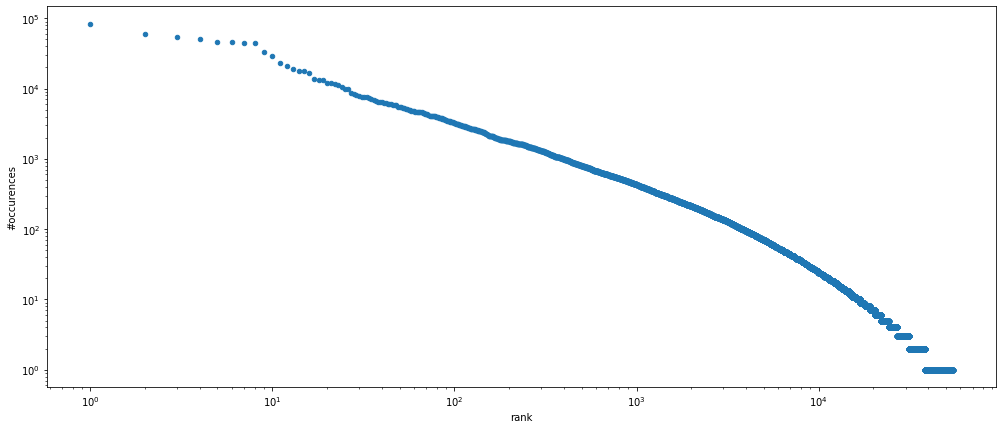

In [13]:
df.plot.scatter(x='rank', y='#occurences', logx=True, logy=True, figsize=(17,7))

### Words that not appear in dictionary

In [14]:
morf = morfeusz2.Morfeusz()
df['in_morfeusz'] = df['word'].apply(lambda x: morf.analyse(x)[0][2][2] != 'ign')

#### Top 30 words with the highest ranks that do not belong to the dictionary

In [15]:
top_unknown_df = df[df['in_morfeusz'] == False][:30]
top_unknown_df

,word,#occurences,rank,in_morfeusz
6,poz,45009,7,False
367,późn,1065,368,False
830,str,514,831,False
1427,gmo,298,1428,False
2018,sww,211,2019,False
2196,skw,193,2197,False
2479,ex,167,2480,False
2551,ike,162,2552,False
3347,remediacji,119,3348,False
3502,zm,112,3503,False


#### 30 random words (i.e. shuffle the words) with 3-7 occurrences that do not belong to the dictionary.

In [16]:
random_unknown_df = df[(df['in_morfeusz'] == False) & (df['#occurences'] >= 3) & (df['#occurences'] <= 7)].sample(n=30)
random_unknown_df

,word,#occurences,rank,in_morfeusz
28081,ktu,3,28082,False
30396,wanej,3,30397,False
24672,harmoniowych,4,24673,False
23339,regazyfikacyjnego,5,23340,False
27639,enodimoczn,3,27640,False
23590,teryto,5,23591,False
22104,betezda,5,22105,False
25425,organicz,4,25426,False
28072,krśt,3,28073,False
19442,moe,7,19443,False


### Finding closest word with Levenshtein metric

In [17]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        total = te-ts
        print(f'func:{f.__name__} args:[{args}] took: {total} sec')
        return result, total
    return wrap

In [36]:
A = 'aąbcćdeęfghijklłmnńoóprsśtuwyzżź'

def generate_additions(word):
    for i in range(len(word)):
        pref = word[:i]
        suf = word[i:]
        for a in A:
            yield pref + a + suf 

    for a in A:
        yield word + a 

def generate_deletions(word):
    for i in range(len(word)):
        yield word[:i] + word[i+1:]
    
def generate_swaps(word):
    for i in range(len(word)):
        pref = word[:i]
        suf = word[i+1:]
        for a in A:
            if a != word[i]:
                yield pref + a + suf

c=0
def check_in_morf(word):
#     cac= morf.analyse(word)[0][2][2] != 'ign'
    global c
    c += 1
#     if c%10000 == 0:
#         print(c)
    return morf.analyse(word)[0][2][2] != 'ign'
    
@timing    
def find_closest(word, max_d=2):
    # bfs
    Q = [(word, 0)]
    vis = { word }
    res = []
    db = -1
    while len(Q) > 0:
        w, d = Q.pop(0)
        if db != -1 and d > db:
            break
        for wa in chain(generate_additions(w), generate_deletions(w), generate_swaps(w)):
            if check_in_morf(wa):
                res.append(wa)
                db = d
            if not wa in vis and d + 1 < max_d:
                Q.append((wa, d+1))
                vis.add(wa)
    
    res = sorted(res, key=lambda a: global_counter[a])
    return res[-1] if len(res) > 0 else None


print(find_closest('rytorialnego'))
print(c)

func:find_closest args:[('rytorialnego',)] took: 12.27536392211914 sec
('terytorialnego', 12.27536392211914)
656288


In [37]:
top_unknown_df['possible_correction'], top_unknown_df['correction_time'] = zip(*top_unknown_df['word'].apply(lambda x: find_closest(x)))
random_unknown_df['possible_correction'], random_unknown_df['correction_time'] = zip(*random_unknown_df['word'].apply(lambda x: find_closest(x)))

func:find_closest args:[('poz',)] took: 0.012103080749511719 sec
func:find_closest args:[('późn',)] took: 0.0069408416748046875 sec
func:find_closest args:[('str',)] took: 0.00780487060546875 sec
func:find_closest args:[('gmo',)] took: 0.004689931869506836 sec
func:find_closest args:[('sww',)] took: 0.0051381587982177734 sec
func:find_closest args:[('skw',)] took: 0.004837989807128906 sec
func:find_closest args:[('ex',)] took: 0.0035474300384521484 sec
func:find_closest args:[('ike',)] took: 0.0049610137939453125 sec
func:find_closest args:[('remediacji',)] took: 0.015084505081176758 sec
func:find_closest args:[('zm',)] took: 0.0030100345611572266 sec
func:find_closest args:[('rozdz',)] took: 0.006978750228881836 sec
func:find_closest args:[('ure',)] took: 0.004024505615234375 sec
func:find_closest args:[('itp',)] took: 0.00403904914855957 sec
func:find_closest args:[('kn',)] took: 0.003744840621948242 sec
func:find_closest args:[('uke',)] took: 0.004289865493774414 sec
func:find_close

In [38]:
top_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
6,poz,45009,7,False,po,0.012103,poz,0.045149
367,późn,1065,368,False,późny,0.006941,Późna,0.032540
830,str,514,831,False,sar,0.007805,str,0.021719
1427,gmo,298,1428,False,go,0.004690,GMC,0.020656
2018,sww,211,2019,False,swe,0.005138,Saw,0.019821
2196,skw,193,2197,False,kw,0.004838,PKW,0.017223
2479,ex,167,2480,False,e,0.003547,EP,0.020870
2551,ike,162,2552,False,ile,0.004961,IKE-ach,0.015430
3347,remediacji,119,3348,False,premediacji,0.015085,repudiacji,0.023359
3502,zm,112,3503,False,z,0.003010,zm,0.019210


In [39]:
random_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
28081,ktu,3,28082,False,kto,0.003927,KTG,0.011409
30396,wanej,3,30397,False,danej,0.006920,Ważnej,0.013762
24672,harmoniowych,4,24673,False,harmonijnych,13.153007,garmondowych,0.017947
23339,regazyfikacyjnego,5,23340,False,pregazyfikacyjnego,0.023272,denazyfikacyjnego,0.016124
27639,enodimoczn,3,27640,False,None,8.680374,None,0.012171
23590,teryto,5,23591,False,teryno,0.008579,teryno,0.017105
22104,betezda,5,22105,False,berezka,4.867173,Berenda,0.012891
25425,organicz,4,25426,False,organicy,0.009926,ogranicz,0.013461
28072,krśt,3,28073,False,krat,0.006426,Krat,0.010586
19442,moe,7,19443,False,może,0.004446,bon-mot,0.011315


### Elastic search fuziness

In [40]:
client = Elasticsearch("http://localhost:9200")

In [41]:
@timing
def find_closest_elastic(word):
    s = Search(using=client, index="sgjp")\
        .query('match', word = { 'query': word, 'fuzziness': 2 })   

    response = s.execute()

    if len(response) == 0:
        return None
    return response[0].word

find_closest_elastic('rytorialnego')

func:find_closest_elastic args:[('rytorialnego',)] took: 0.02438211441040039 sec


('terytorialnego', 0.02438211441040039)

In [42]:
top_unknown_df['possible_correction_elastic'], top_unknown_df['correction_time_elastic'] = zip(*top_unknown_df['word'].apply(lambda x: find_closest_elastic(x)))
random_unknown_df['possible_correction_elastic'], random_unknown_df['correction_time_elastic'] = zip(*random_unknown_df['word'].apply(lambda x: find_closest_elastic(x)))

func:find_closest_elastic args:[('poz',)] took: 0.01309823989868164 sec
func:find_closest_elastic args:[('późn',)] took: 0.013649940490722656 sec
func:find_closest_elastic args:[('str',)] took: 0.009479761123657227 sec
func:find_closest_elastic args:[('gmo',)] took: 0.009317636489868164 sec
func:find_closest_elastic args:[('sww',)] took: 0.011016607284545898 sec
func:find_closest_elastic args:[('skw',)] took: 0.009475231170654297 sec
func:find_closest_elastic args:[('ex',)] took: 0.009870529174804688 sec
func:find_closest_elastic args:[('ike',)] took: 0.010529756546020508 sec
func:find_closest_elastic args:[('remediacji',)] took: 0.01331329345703125 sec
func:find_closest_elastic args:[('zm',)] took: 0.00988316535949707 sec
func:find_closest_elastic args:[('rozdz',)] took: 0.014422416687011719 sec
func:find_closest_elastic args:[('ure',)] took: 0.010622978210449219 sec
func:find_closest_elastic args:[('itp',)] took: 0.009460926055908203 sec
func:find_closest_elastic args:[('kn',)] took:

In [43]:
top_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
6,poz,45009,7,False,po,0.012103,poz,0.013098
367,późn,1065,368,False,późny,0.006941,Późna,0.013650
830,str,514,831,False,sar,0.007805,str,0.009480
1427,gmo,298,1428,False,go,0.004690,GMC,0.009318
2018,sww,211,2019,False,swe,0.005138,Saw,0.011017
2196,skw,193,2197,False,kw,0.004838,PKW,0.009475
2479,ex,167,2480,False,e,0.003547,EP,0.009871
2551,ike,162,2552,False,ile,0.004961,IKE-ach,0.010530
3347,remediacji,119,3348,False,premediacji,0.015085,repudiacji,0.013313
3502,zm,112,3503,False,z,0.003010,zm,0.009883


In [44]:
random_unknown_df

,word,#occurences,rank,in_morfeusz,possible_correction,correction_time,possible_correction_elastic,correction_time_elastic
28081,ktu,3,28082,False,kto,0.003927,KTG,0.008883
30396,wanej,3,30397,False,danej,0.006920,Ważnej,0.011501
24672,harmoniowych,4,24673,False,harmonijnych,13.153007,garmondowych,0.020456
23339,regazyfikacyjnego,5,23340,False,pregazyfikacyjnego,0.023272,denazyfikacyjnego,0.015725
27639,enodimoczn,3,27640,False,None,8.680374,None,0.012911
23590,teryto,5,23591,False,teryno,0.008579,teryno,0.016217
22104,betezda,5,22105,False,berezka,4.867173,Berenda,0.015515
25425,organicz,4,25426,False,organicy,0.009926,ogranicz,0.017438
28072,krśt,3,28073,False,krat,0.006426,Krat,0.010972
19442,moe,7,19443,False,może,0.004446,bon-mot,0.012499


### Conclusion

We might think that there should never be a case in which exactly one of proposed correction is None. It is not true. Examples are: biobójczych, interkalibracyjnych. Corrections are found by levenshtein method and not by elastic. It happened because the corrections proposed by the first algorithm are not in the dictionary provided by morfeusz, but morfeusz.analyze method can find them.

<AxesSubplot:>

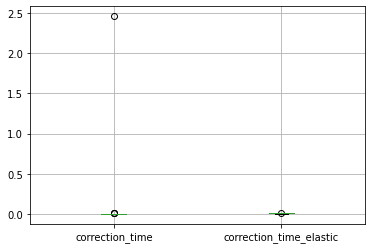

In [45]:
top_unknown_df.boxplot(column=['correction_time', 'correction_time_elastic'])

<AxesSubplot:>

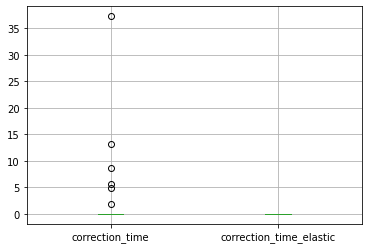

In [46]:
random_unknown_df.boxplot(column=['correction_time', 'correction_time_elastic'])

Comparing time of both methods we can notice that elastic is much more stable when it comes to execution time. In the manual method there are many outliers.\
Almost all solutions are different. Both method usually don't agree on the results.

Not always the solution found by algorithm seems to be correct for human. Example:\
word: naturalneg\
we expect: naturalnego\
levenshtein generation: naturalne\
elastic: naturalny

Distribution of the words on a chart without logaritmic scale would be hiperbolic. It means that there are a few words that appears very often, ex. 'ustawa'. It sounds reasonable because this word belengs to domain language. 

It is hard to determine if the word is true mispelling or unknown word. We have to go through each of the word to determine it. Kind of method would be to check frequency list but it might be not always correct. 